# Final Project Submission
## Please fill out:

* Student name: Nastaran Nazemian
* Student pace: part time
* Scheduled project review date/time: 10/19/2020 11:00PM (PS)
* Instructor name: Lindsey Berlin
* Blog post URL:

# Introduction

Recommending people to buy what they think they need or near to what they used to use in past is one of the most effective way to encourage people to buy more. A recommender system, or a recommendation system is one of the ways that seeks to predict the "rating" or "preference" a user would give to an item.

This thickness is utilized in a variety of areas such as playlist generators for video and music services like MovieLens, that helps you find movies you will like. Rate movies to build a custom taste profile, then MovieLens recommends other movies for you to watch.

The dataset that I have used in this project is from a movie recommendation service, MovieLens. This dataset contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


In [1]:
#import libraries
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('error')
# For merging 3 dataframe
import re
from functools import reduce

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.prediction_algorithms import knns, SVD

# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [2]:
# read zip file
with zipfile.ZipFile("ml-latest-small.zip","r") as zip_ref:
    zip_ref.extractall()

In [3]:
# pull csv file
txtfiles = []
for file in glob.glob('C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small/*.csv'):
    txtfiles.append(file)
txtfiles 

['C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small\\links.csv',
 'C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small\\movies.csv',
 'C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small\\ratings.csv',
 'C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small\\tags.csv']

In [4]:
# Load each csv files into a dataframe
# links_df = pd.read_csv("ml-latest-small/links.csv")
# tags_df = pd.read_csv("ml-latest-small/tags.csv")
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

In [5]:
# print each dataframe and look at the info
# print(links_df.info())
# links_df.head()
# print(tags_df.info())
# tags_df.head()
print(ratings_df.info())
ratings_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
print(movies_df.info())
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# drop timestamp columns from ratings and tags
#tags_df.drop(columns=['timestamp'], inplace=True)
ratings_df.drop(columns=['timestamp'], inplace=True)


In [8]:
# print('links_df:',links_df.shape,' ','columns_name:', links_df.columns)
# print('tags_df:', tags_df.shape,' ','columns_name:', tags_df.columns)
print('ratings_df:', ratings_df.shape,' ','columns_name:',ratings_df.columns)
print('movies_df:', movies_df.shape,' ','columns_name:',movies_df.columns )

ratings_df: (100836, 3)   columns_name: Index(['userId', 'movieId', 'rating'], dtype='object')
movies_df: (9742, 3)   columns_name: Index(['movieId', 'title', 'genres'], dtype='object')


In [9]:
#merging the dataframes 
df = pd.merge(movies_df, ratings_df)

In [10]:
df.shape

(100836, 5)

In [11]:
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100836 non-null  int64  
 1   title    100836 non-null  object 
 2   genres   100836 non-null  object 
 3   userId   100836 non-null  int64  
 4   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


In [13]:
df.isna().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

In [14]:
df = df.loc[df.genres !='(no genres listed)'] 
df.shape

(100789, 5)

In [15]:
#define functions 
#import re
p = re.compile("([0-9]{4})")
def Movie_Year(title_str):
    result = p.search(title_str)
    if result:
        a = float(result.group())
    else:
        a = float("nan")
    return a

l = re.compile("([a-zA-Z, ]*)")
def Title_NoYear(title_str):
    result = p.search(title_str)
    if result:
        result1 = l.search(title_str)
        a = result1.group(1)
    else:
        a = title_str
    return a

def plot_func(title,x_axes, y_axes,data_df, color ):
    f, ax = plt.subplots(figsize=(20,10))
    sns.set(style="whitegrid")
    ax.set_title(title, y=1.2, fontsize=20, ha='center').set_position([0.5,1.08])
    ax = sns.barplot(x=x_axes, y=y_axes , data= data_df, palette=color)

In [16]:
df['year'] =list(map(lambda x: Movie_Year(x), df.title))
df['year'] = df['year'].astype('Int64')

In [17]:
df['no_year_title'] =list(map(lambda x: Title_NoYear(x), df.title))
df['no_year_title'].head()

0    Toy Story 
1    Toy Story 
2    Toy Story 
3    Toy Story 
4    Toy Story 
Name: no_year_title, dtype: object

In [18]:
df = df.loc[df.no_year_title !='']
df.shape

(99195, 7)

In [19]:
df.head()

,movieId,title,genres,userId,rating,year,no_year_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995,Toy Story
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995,Toy Story
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995,Toy Story
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995,Toy Story
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995,Toy Story


In [20]:
df.isna().sum()

movieId          0
title            0
genres           0
userId           0
rating           0
year             8
no_year_title    0
dtype: int64

In [21]:
df.loc[df.year.isna()]

,movieId,title,genres,userId,rating,year,no_year_title
81292,40697,Babylon 5,Sci-Fi,210,4.0,<NA>,Babylon 5
81293,40697,Babylon 5,Sci-Fi,528,0.5,<NA>,Babylon 5
99325,140956,Ready Player One,Action|Sci-Fi|Thriller,209,3.5,<NA>,Ready Player One
99326,140956,Ready Player One,Action|Sci-Fi|Thriller,305,4.5,<NA>,Ready Player One
99327,140956,Ready Player One,Action|Sci-Fi|Thriller,380,3.0,<NA>,Ready Player One
99328,140956,Ready Player One,Action|Sci-Fi|Thriller,514,3.0,<NA>,Ready Player One
99617,149334,Nocturnal Animals,Drama|Thriller,306,3.0,<NA>,Nocturnal Animals
100051,162414,Moonlight,Drama,462,5.0,<NA>,Moonlight


In [22]:
df.year.sort_values(ascending=True).unique()

<IntegerArray>
[1000, 1138, 1600, 1900, 1902, 1903, 1908, 1915, 1916, 1917,
 ...
 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2049, 3000, <NA>]
Length: 113, dtype: Int64

In [23]:
df.dtypes

movieId            int64
title             object
genres            object
userId             int64
rating           float64
year               Int64
no_year_title     object
dtype: object

In [24]:
year_df = df.loc[(df.year >1899) & (df.year < 2020)]
year_df.year.sort_values().unique()
len(year_df.year.unique())

107

Text(0.5, 0, 'Year')

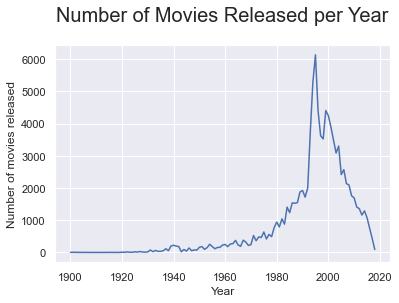

In [25]:
df_movie_year = year_df.groupby('year').agg({'year': 'count'})
df_movie_year.rename(columns={'year': 'year_count'}, inplace = True)
df_movie_year = df_movie_year.reset_index()
sns.set_theme(style="darkgrid")

# # Plot the responses for different events and regions
ax =sns.lineplot(x="year", y="year_count", data=df_movie_year)
ax.set_title("Number of Movies Released per Year", y=1.2, fontsize=20, ha='center').set_position([0.5,1.08])
ax.set_ylabel('Number of movies released')
ax.set_xlabel('Year')

In [26]:
#Split the a movie genres
df1 = df.copy()
df1['genres'] = df['genres'].str.split('|')

#creat a flattent dataframe
flatten_df = df1['genres'].apply(pd.Series) \
        .merge(df, right_index = True, left_index = True) \
        .drop(['genres'], axis = 1) \
        .melt(id_vars = df.columns.drop('genres'), value_name = "genres") \
        .drop("variable", axis = 1) \
        .dropna(subset=['genres'])


In [27]:
flatten_df.genres.unique()

array(['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', 'Children',
       'Mystery', 'Animation', 'Documentary', 'Thriller', 'Horror',
       'Fantasy', 'Western', 'Film-Noir', 'Romance', 'Sci-Fi', 'Musical',
       'War', 'IMAX'], dtype=object)

In [28]:
# flatten_df = flatten_df.loc[flatten_df.genres !='(no genres listed)']
 flatten_df.shape

(270418, 7)

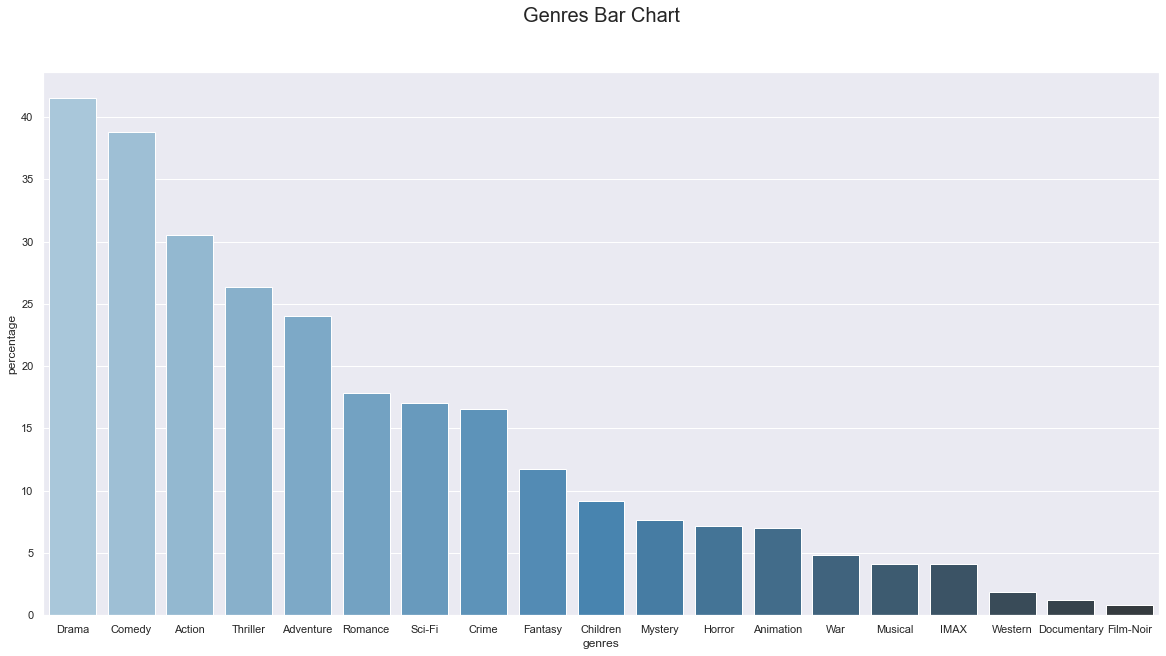

In [29]:
flatten_df = flatten_df.loc[(flatten_df.year >1899) & (flatten_df.year < 2020)]
genres_df = flatten_df.groupby('genres').agg({'genres': 'count'})
genres_df['percentage'] = round(genres_df['genres'] * 100 / df.shape[0],2)
genres_df.rename(columns={'genres': 'genres_count'}, inplace = True)
genres_df = genres_df.reset_index()
genres_df.sort_values(by='percentage', ascending=False, inplace=True)
genres_df.head()
plot_func('Genres Bar Chart','genres', 'percentage', genres_df,"Blues_d" )

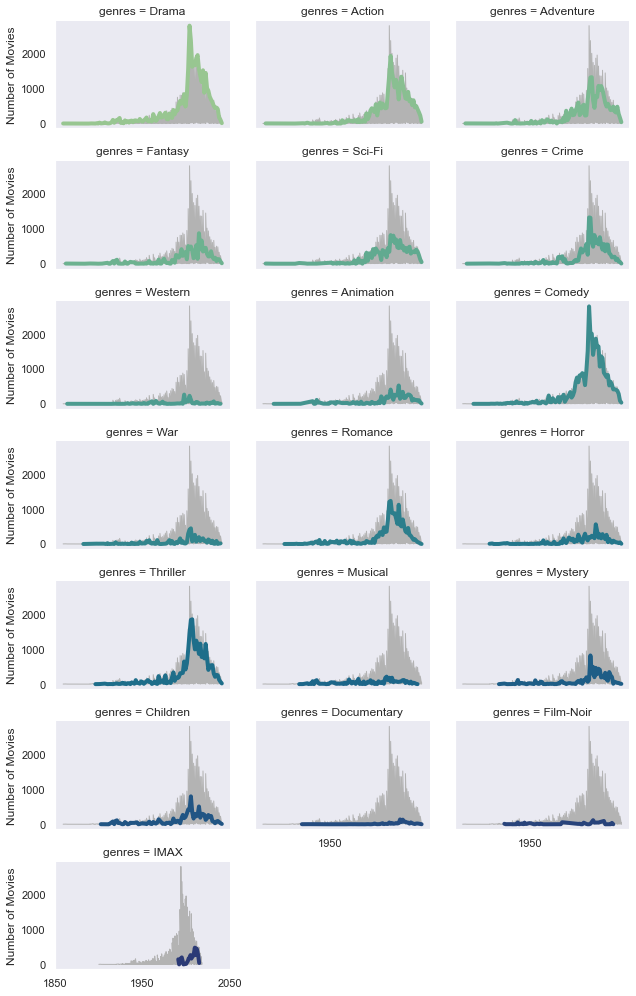

In [30]:
sns.set_theme(style="dark")
new_df = flatten_df.groupby(['year','genres']).agg({'year': 'count'})
new_df.rename(columns={'year': 'year_count'}, inplace = True)
new_df = new_df.reset_index()
# Plot each year's time series in its own facet
g = sns.relplot(
    data=new_df,
    x="year", y="year_count", col="genres",hue="genres", 
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    #ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=new_df, x="year", y="year_count", 
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
#g.ax.set_title("Yearly Movie Production count by Genrea ")
g.set_axis_labels("", 'Number of Movies')
g.tight_layout()

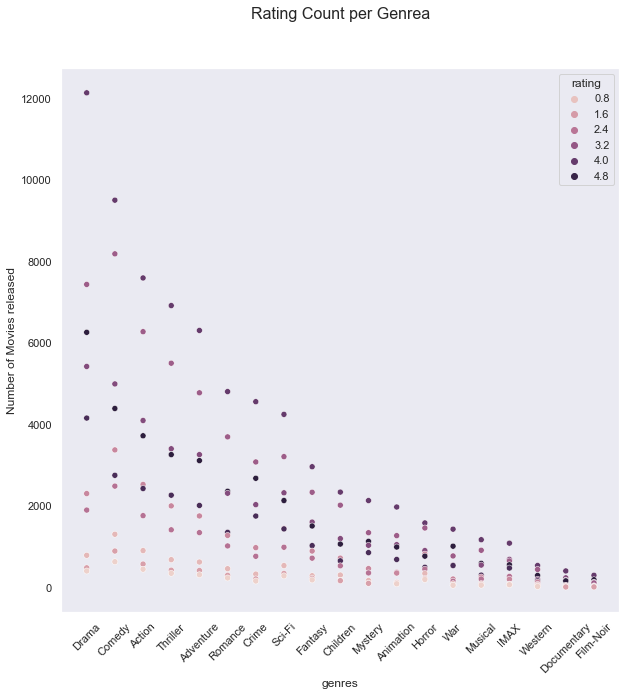

In [31]:
ave_rating_df = flatten_df.groupby(['genres','rating']).agg({'movieId': 'count'})
ave_rating_df = ave_rating_df.reset_index()
ave_rating_df.sort_values(by='movieId', ascending=False, inplace=True)


plt.figure(figsize=(10,10))

chart = sns.scatterplot(x = ave_rating_df.genres, y = ave_rating_df.movieId, hue=ave_rating_df.rating)

plt.setp(chart.get_xticklabels(), rotation=45)
chart.set_title("Rating Count per Genrea", y=1.2, fontsize=16, ha='center').set_position([0.5,1.08])
chart.set_ylabel('Number of Movies released')



plt.show()

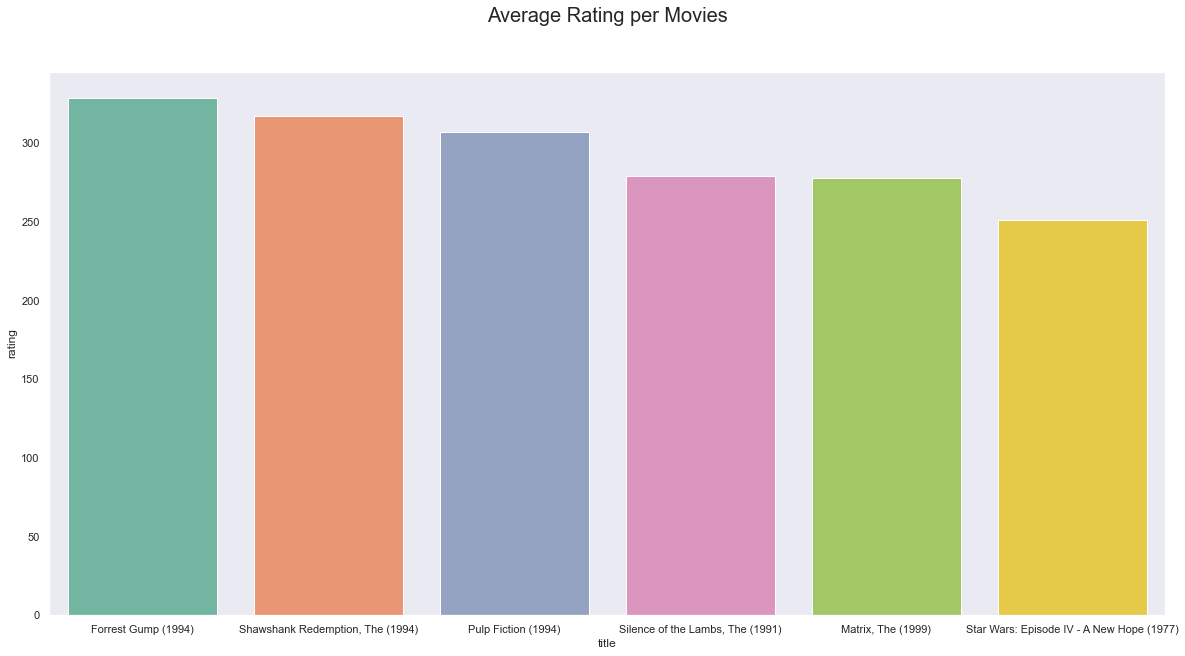

In [32]:
df_title = df.groupby('title').agg({'rating': 'count'}).sort_values(by='rating', ascending=False)
df_title = df_title.reset_index()
plot_func('Average Rating per Movies','title', 'rating', df_title[:6], 'Set2' )

In [33]:
df_title.head(20)

,title,rating
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


In [34]:
df_title.title.unique()

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', ...,
       'Kizumonogatari Part 1: Tekketsu (2016)',
       'Kizumonogatari III: Cold Blood (2017)', 'Last Legion, The (2007)'],
      dtype=object)

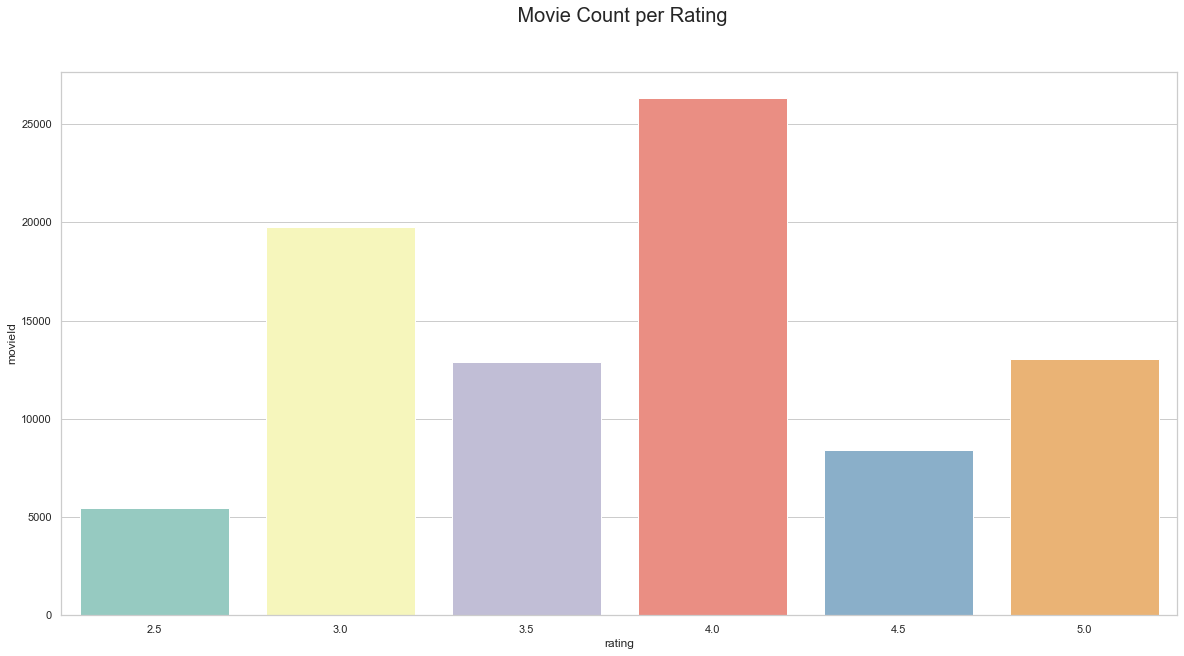

In [35]:
df_rating = df.groupby('rating').agg({'movieId': 'count'}).sort_values(by='rating', ascending=False)
df_rating = df_rating.reset_index()
plot_func(' Movie Count per Rating','rating', 'movieId', df_rating[:6],'Set3' )

# Modeling

In [36]:
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)
dataset = data.build_full_trainset()

In [37]:
type(dataset)

surprise.trainset.Trainset

In [38]:
print(dataset.n_users)
print(dataset.n_items)
print(dataset.n_ratings)

610
9724
100836


In [39]:
trainset, testset = train_test_split(data, test_size=0.2)
print(len(testset))
print(testset[0])

20168
(19, 1240, 4.0)


In [40]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  610 

Number of items:  8914 



In [41]:
sim_cos = {'name':'cosine', 'user_based':False}
#name': ['cosine', 'pearson', 'MSD', 'pearson_baseline']
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9790
0.9790162371835731


In [42]:
basic = knns.KNNBaseline(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8959
0.8959087655053966


In [43]:
basic = knns.KNNWithMeans(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9068
0.9067591713058563


In [44]:
basic = knns.KNNWithZScore(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9127
0.9126605819910375


In [45]:
svd = SVD(n_factors=20, n_epochs=10, lr_all=0.0005, reg_all=0.4)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9430
0.9429619141996384


In [46]:
# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [47]:
movie_ratings = spark.read.csv('C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small/ratings.csv', header='true', inferSchema='true')

In [48]:
movie_ratings.dtypes

[('userId', 'int'),
 ('movieId', 'int'),
 ('rating', 'double'),
 ('timestamp', 'int')]

In [49]:
movie_ratings = movie_ratings.drop('timestamp')

In [50]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [51]:
# importing appropriate library
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9632791887517774


In [52]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

Py4JJavaError: An error occurred while calling o132.evaluate.
: org.apache.spark.SparkException: Job 110 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:932)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:930)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:78)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:930)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2128)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2041)
	at org.apache.spark.SparkContext$$anonfun$stop$6.apply$mcV$sp(SparkContext.scala:1949)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1340)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1948)
	at org.apache.spark.SparkContext$$anonfun$2.apply$mcV$sp(SparkContext.scala:575)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:216)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary$lzycompute(RegressionMetrics.scala:57)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary(RegressionMetrics.scala:54)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSerr$lzycompute(RegressionMetrics.scala:65)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSerr(RegressionMetrics.scala:65)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.meanSquaredError(RegressionMetrics.scala:100)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.rootMeanSquaredError(RegressionMetrics.scala:109)
	at org.apache.spark.ml.evaluation.RegressionEvaluator.evaluate(RegressionEvaluator.scala:86)
	at sun.reflect.GeneratedMethodAccessor107.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
movie_titles = spark.read.csv('C:/Flatiron/course-material/ModuleFourFinalProject/Recommendation/ml-latest-small/movies.csv',header='true',inferSchema='true')
movie_titles.head(5)

In [ ]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [ ]:
print(name_retriever(1023, movie_titles))

In [ ]:
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [ ]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

In [ ]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

In [ ]:
movieRecs = model.recommendForAllItems(10)
movieRecs.where(movieRecs.movieId == 3).collect()

In [ ]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [ ]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df=movie_titles,
             num_recs = 10)

In [ ]:
user_ratings = movie_ratings.pivot(index='userId', columns='movieId', values='rating')
user_ratings.head()

In [ ]:
for col in user_ratings:
    mean = user_ratings[col].mean()
    user_ratings[col] = user_ratings[col].fillna(value=mean)
user_ratings.head()

In [ ]:
import numpy as np
import datetime

u1 = user_ratings.iloc[1]
u2 = user_ratings.iloc[2]
def distance(v1,v2):
    return np.sqrt(np.sum((v1-v2)**2))
distance(u1,u2)

In [ ]:
# ⏰ Expect this cell to take several minutes to run
start = datetime.datetime.now()
user_matrix = []
for i, row in enumerate(user_ratings.index):
    u1 = user_ratings[row]
    # Matrix is symetric, so fill in values for previously examined users
    user_distances = [entry[i] for entry in user_matrix] 
    for j, row2 in enumerate(user_ratings.index[i:]):
        u2 = user_ratings[row2]
        d = distance(u1,u2)
        user_distances.append(d)
    user_matrix.append(user_distances)
user_similarities = pd.DataFrame(user_matrix)

end = datetime.datetime.now()
elapsed = end - start
print(elapsed)

user_similarities.head()

In [ ]:
def recommend_movies(user, user_similarities, user_ratings, df, n_users=20, n_items=10):
    """n is the number of similar users who you wish to use to generate recommendations."""
    # User_Similarities Offset By 1 and Must Remove Current User
    top_n_similar_users = user_similarities[user-1].drop(user-1).sort_values().index[:n_users] 
    # Again, fixing the offset of user_ids
    top_n_similar_users = [i+1 for i in top_n_similar_users] 
    already_watched = set(df[df.user_id == 0].item_id.unique())
    unwatched = set(df.item_id.unique()) - already_watched
    projected_user_reviews = user_ratings[user_ratings.index.isin(top_n_similar_users)].mean()[list(unwatched)].sort_values(ascending=False)
    return projected_user_reviews[:n_items]

In [ ]:
recommend_movies(1, user_similarities, user_ratings,movie_ratings )